## Training a Quantum Model on a Real Dataset


Welcome to this tutorial on training a quantum machine learning model for a classification problem using the Iris flower dataset. In this tutorial, we'll move beyond artificial datasets and tackle a real-life classification problem. We've chosen the Iris flower dataset for its simplicity and widespread use in the data science community.

The Iris dataset is a well-known dataset in the field of machine learning, so we'll briefly introduce it to refresh our memories. It consists of measurements of iris flowers from three different species: Setosa, Versicolor, and Virginica. Each sample contains four features: sepal length, sepal width, petal length, and petal width.

Here's an outline of what we'll cover in this tutorial:

1. Loading and Exploring the Dataset: We'll start by loading the Iris dataset and exploring its structure and contents.

2. Training a Classical Model: Before diving into quantum machine learning, we'll train a classical support vector machine (SVC) model using scikit-learn. This will serve as a baseline for comparison with our quantum model.

3. Introducing the Variational Quantum Classifier (VQC): We'll introduce the Variational Quantum Classifier (VQC), a quantum machine learning algorithm that can be used for classification tasks.

4. Comparing Results: Finally, we'll compare the performance of the classical SVC model with the VQC model to understand the strengths and limitations of each approach.

By the end of this tutorial, we'll have a better understanding of how to leverage quantum computing for machine learning tasks and how it compares to classical methods.

Let's get started!


[The source of this notebook](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html)

### 1. Loading and Exploring the Dataset

In [41]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [42]:
print(iris_data.DESCR)


.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Before delving into our exploration of the Iris flower dataset, let's take a moment to observe its characteristics:

1. Size and Structure: The dataset comprises 150 samples, each with four distinct features. These features include sepal length, sepal width, petal length, and petal width.

2. Class Distribution: Across the dataset, we observe a balanced distribution among three distinct classes: Setosa, Versicolor, and Virginica. Each class contains precisely 50 samples.

3. Feature Scaling: Notably, the features exhibit varying scales, with sepal length ranging from 4.3 to 7.9 and petal width from 0.1 to 2.5. Normalizing these features to a consistent scale could enhance our model's performance.

4. Feature-Class Relationships: Upon closer examination, we notice significant correlations between certain features and classes. This suggests that our model may effectively leverage these relationships to classify the data accurately.

Having gleaned these insights from the dataset description, we are well-equipped to proceed with our analysis. Let's now delve into the features and labels of the Iris dataset to uncover further insights.

In [43]:
features = iris_data.data
labels = iris_data.target

To ensure consistent processing of our features, we'll begin by applying normalization. This process involves transforming the feature values to a common scale, which is crucial for enhancing the stability and convergence of our machine learning algorithms.

In our approach, we'll leverage the Min-Max Scaling technique, available through the MinMaxScaler module in scikit-learn. This technique maps our feature data onto the interval [0, 1] without requiring any additional parameters, making it a straightforward and efficient method for our purposes.

By standardizing our feature values in this manner, we'll ensure that each feature contributes equally to our analysis, ultimately facilitating more robust and reliable results.

In [44]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

Let’s see how our data looks. We plot the features pair-wise to see if there’s an observable correlation between them.

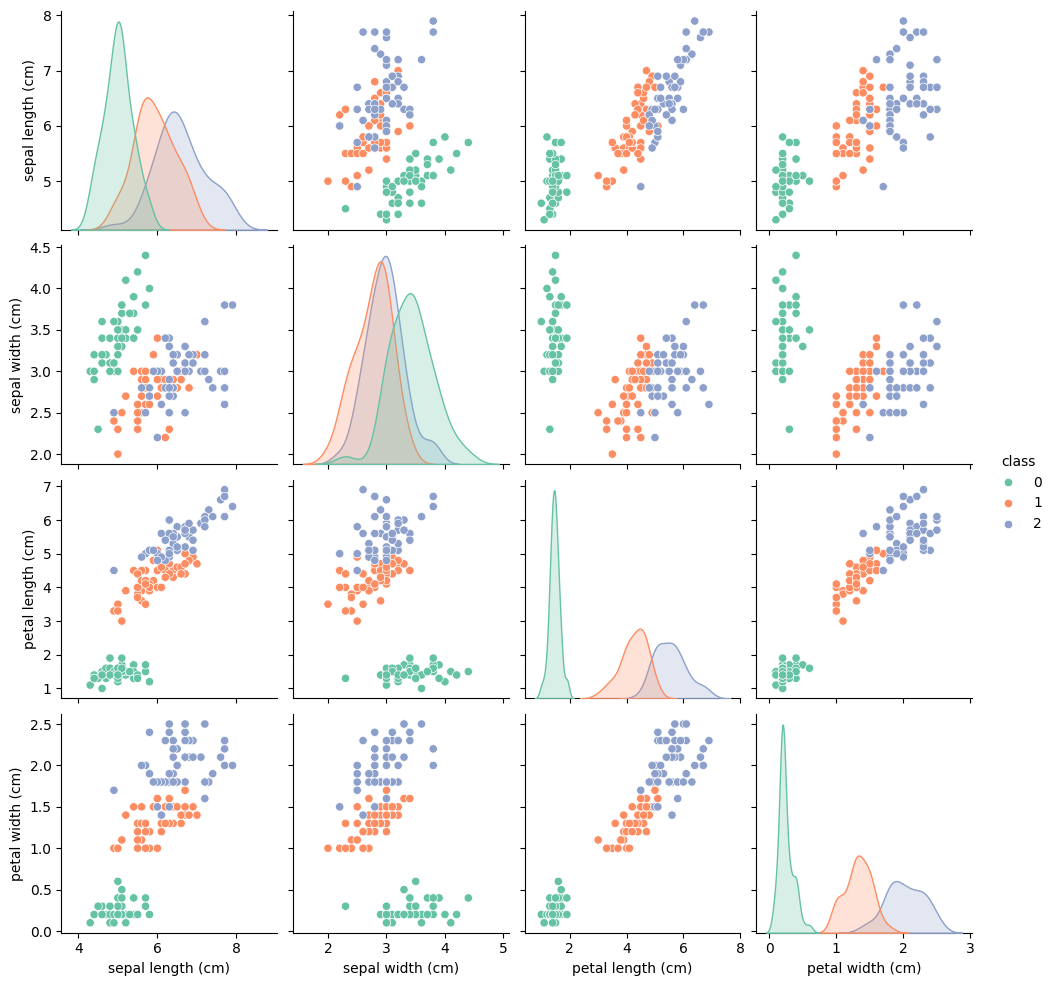

In [45]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="Set2")


From the plots, we see that class 0 is easily separable from the other two classes, while classes 1 and 2 are sometimes intertwined, especially regarding the “sepal width” feature.

Next, let’s see how classical machine learning handles this dataset.

### 2. Training a Classical Machine Learning Model

Before we train a model, we should split the dataset into two parts: a training dataset and a test dataset. We’ll use the former to train the model and the latter to verify how well our models perform on unseen data.

As usual, we’ll ask scikit-learn to do the boring job for us. We’ll also fix the seed to ensure the results are reproducible.

In [46]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


We train a classical Support Vector Classifier from scikit-learn. For the sake of simplicity, we don’t tweak any parameters and rely on the default values.



In [47]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

Now we check out how well our classical model performs. We will analyze the scores in the conclusion section.

In [48]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


As can be seen from the scores, the classical SVC algorithm performs very well. Next up, it’s time to look at quantum machine learning models.

### 3. Training a Quantum Machine Learning Model (Variant Quantum Classifier aka VQC)

In this part of the notebook, we'll explore the implementation of a variational quantum classifier (VQC), a fundamental quantum machine learning model available in Qiskit Machine Learning. The VQC serves as an excellent introduction to quantum machine learning for those familiar with classical machine learning techniques.

Before diving into model training, let's take a closer look at the key components of the VQC class: the feature map and the ansatz.

Feature Map: As our input data is classical, represented by a set of bits rather than qubits, we need a method to encode this data into a quantum format. This process, known as data encoding or embedding, is facilitated by the feature map. Unlike classical machine learning, where feature mapping is a common mechanism, the concept of loading data into quantum states is unique to quantum machine learning.

Ansatz: Once the data is encoded, we apply a parameterized quantum circuit, analogous to the layers in classical neural networks. This circuit, also known as a parameterized trial state or variational form, contains tunable parameters or weights. These weights are optimized to minimize an objective function, which measures the discrepancy between predictions and known labeled data.

For further exploration and understanding, interested readers can refer to the [Quantum Machine Learning Course GitHub repository](https://github.com/Qiskit/textbook/tree/main/notebooks/quantum-machine-learning#).

For our implementation, we'll utilize the ZZFeatureMap, a standard feature map provided in the Qiskit circuit library. We'll configure the feature map with a feature dimension of 4 qubits, corresponding to the number of features in our dataset.

Additionally, we'll decompose the feature map into its constituent gates to provide insight into its inner workings.

This comprehensive overview sets the stage for our exploration of quantum machine learning techniques, demonstrating how classical data can be harnessed and processed in a quantum framework.

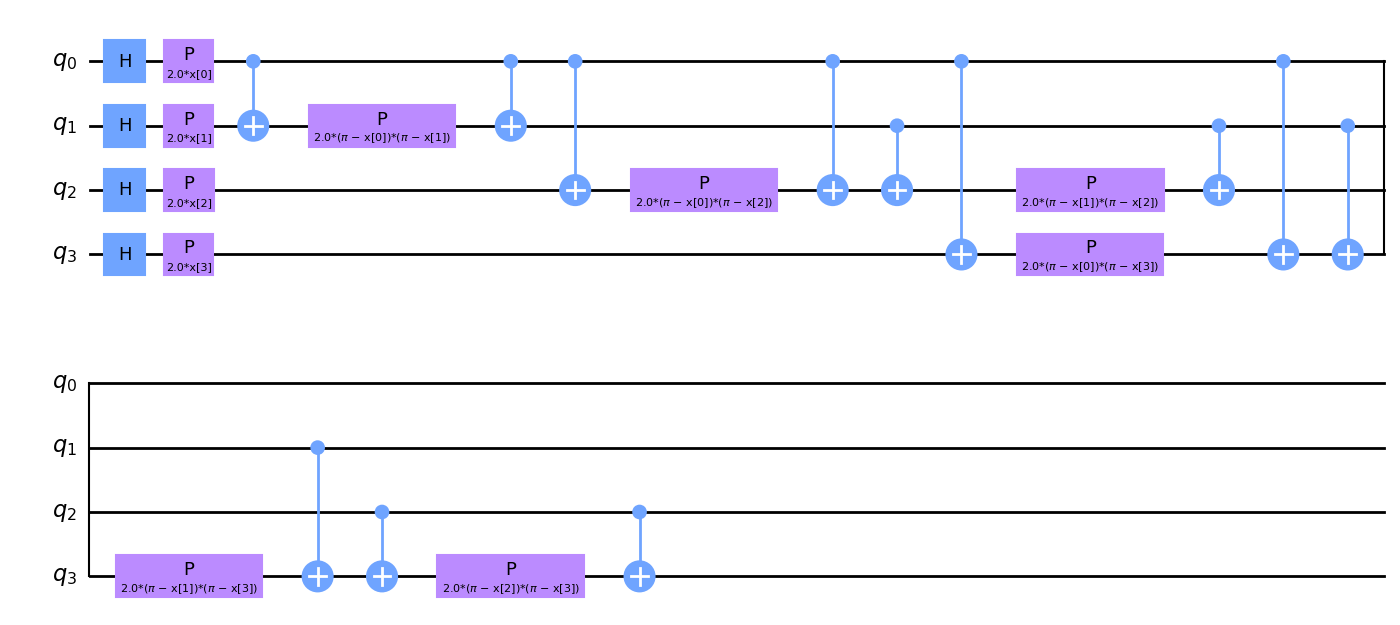

In [49]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

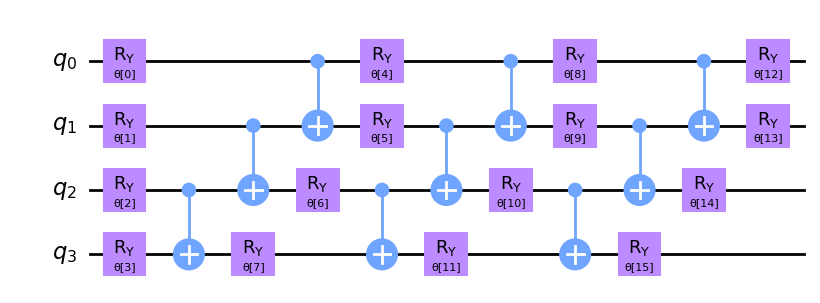

In [50]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)


This circuit has 16 parameters named θ[0], ..., θ[15]. These are the trainable weights of the classifier.

We then choose an optimization algorithm to use in the training process. This step is similar to what you may find in classical deep learning frameworks. To make the training process faster, we choose a gradient-free optimizer. You may explore other optimizers available in Qiskit.

In [51]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In the next step, we define where to train our classifier. We can train on a simulator or a real quantum computer. Here, we will use a simulator. We create an instance of the Sampler primitive. This is the reference implementation that is statevector based. Using qiskit runtime services you can create a sampler that is backed by a quantum computer.

In [52]:
from qiskit.primitives import Sampler

sampler = Sampler()

As we embark on training our variational quantum classifier (VQC), we'll incorporate a useful callback function named callback_graph. This function plays a pivotal role in tracking the optimization process by capturing the value of the objective function at each iteration.

The callback_graph function is invoked by the VQC for every evaluation of the objective function. It receives two parameters: the current weights and the corresponding value of the objective function. Within this callback, we'll maintain an array to store these objective function values, facilitating the creation of an iteration-versus-objective-function-value plot.

At each iteration, the callback dynamically updates the plot, providing real-time insights into the optimization progress. It's worth noting that the callback function affords flexibility, allowing for customization beyond simply plotting the objective function. As long as the function maintains the specified two-parameter signature, users have the freedom to tailor it to their specific requirements.

With the callback_graph function in place, we're equipped to monitor and analyze the optimization journey of our VQC model, ensuring transparency and facilitating informed decision-making throughout the training process.

In [53]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Now we are ready to construct the classifier and fit it.

VQC stands for “variational quantum classifier.” It takes a feature map and an ansatz and constructs a quantum neural network automatically. In the simplest case it is enough to pass the number of qubits and a quantum instance to construct a valid classifier. You may omit the sampler parameter, in this case a Sampler instance will be created for you in the way we created it earlier. We created it manually for illustrative purposes only.

Training may take some time. Please, be patient.

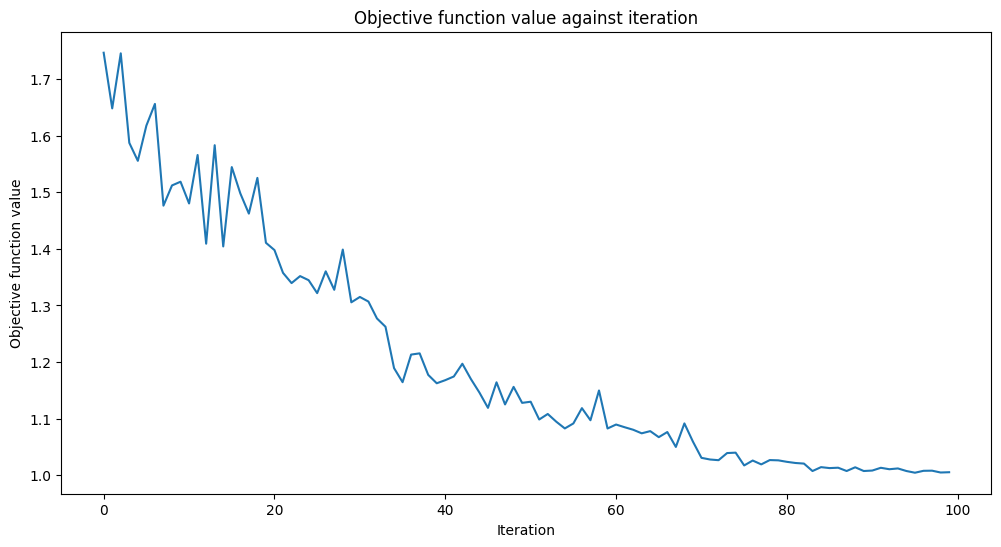

Training time: 27 seconds


In [54]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Let’s see how the quantum model performs on the real-life dataset.

In [55]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.85
Quantum VQC on the test dataset:     0.87


Having observed the promising scores attained by our model, it's evident that it possesses the capability to make accurate predictions on unseen data. However, in our pursuit of excellence, let's explore avenues for further refinement.

Two pivotal components warrant our attention: the feature map and the ansatz. By adjusting parameters such as the reps parameter, which dictates the number of gate pattern repetitions added to the circuit, we can fine-tune the model's performance. Increasing reps enhances flexibility by introducing more entanglement operations and parameters. However, this comes at the cost of heightened complexity and potentially longer training times, with the risk of overfitting looming large. Experimenting with alternative feature maps and ansatzes from the Qiskit circuit library or devising custom circuits offers additional avenues for exploration.

Furthermore, the choice of optimizer plays a crucial role in model optimization. Qiskit offers a diverse array of optimizers, ranging from gradient-free to gradient-based options like L_BFGS_B. While gradient-based optimizers may yield superior results, they often necessitate increased training time due to the evaluation of gradients with respect to training parameters, leading to a higher number of circuit executions per iteration.

Exploring alternative initialization strategies, such as random or deterministic sampling of initial_point, and iteratively fitting the model, presents yet another avenue for enhancing model robustness.

Lastly, it's essential to consider scenarios where the dataset exceeds the quantum computer's capacity. While our example aligns the number of qubits with the dataset's feature count, this alignment may not always be feasible. In such cases, strategic feature selection or dimensionality reduction techniques may be warranted to ensure compatibility with quantum hardware limitations.

### 3.5 Reducing the Number of Features

In this section, we reduce the number of features in our dataset and train our models again. We’ll move through faster this time as the steps are the same except for the first, where we apply a PCA transformation.

We transform our four features into two features only. This dimensionality reduction is for educational purposes only. As you saw in the previous section, we can train a quantum model using all four features from the dataset.

Now, we can easily plot these two features on a single figure.

<Axes: >

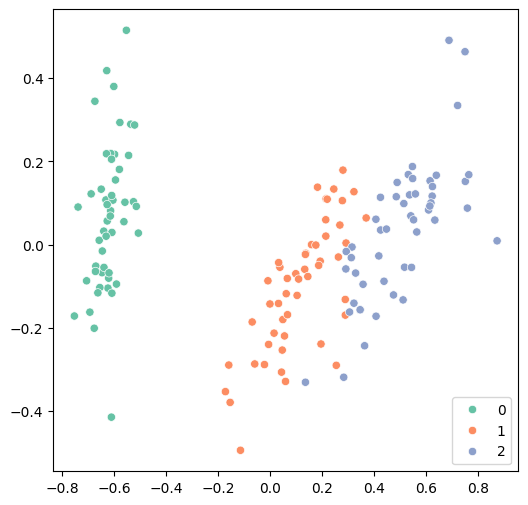

In [56]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="Set2")

In [57]:
### As usual, we split the dataset first, then fit a classical model.

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


The results are still good. Let’s see how a quantum model deals with them. As we now have two qubits, we must recreate the feature map and ansatz.

In [58]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

We also reduce the maximum number of iterations we run the optimization process for, as we expect it to converge faster because we now have fewer qubits.

In [59]:
optimizer = COBYLA(maxiter=40)

Now we construct a quantum classifier from the new parameters and train it.

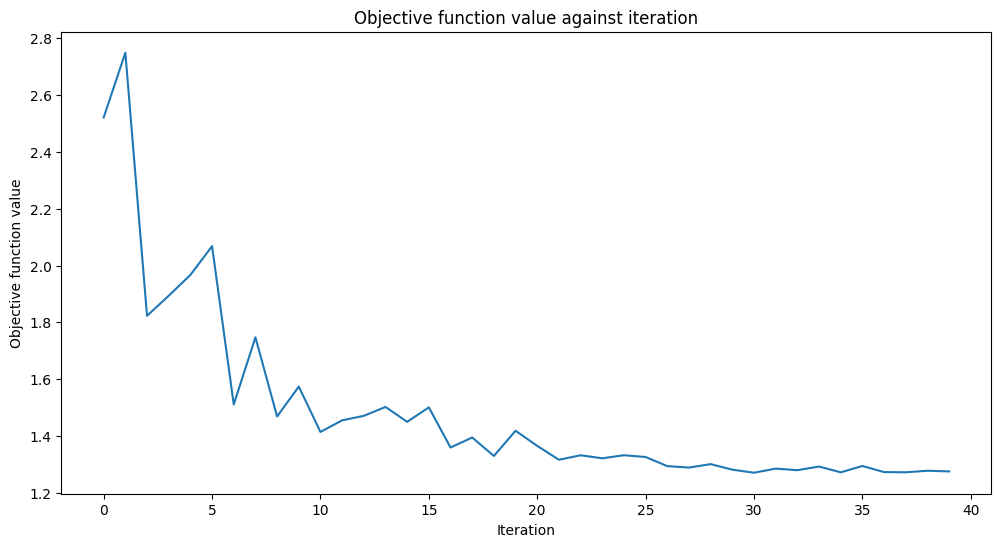

Training time: 7 seconds


In [60]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [62]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.58
Quantum VQC on the test dataset using RealAmplitudes:     0.63


Well, the scores are higher than a fair coin toss but could be better. The objective function is almost flat towards the end, meaning increasing the number of iterations won’t help, and model performance will stay the same. Let’s see what we can do with another ansatz.

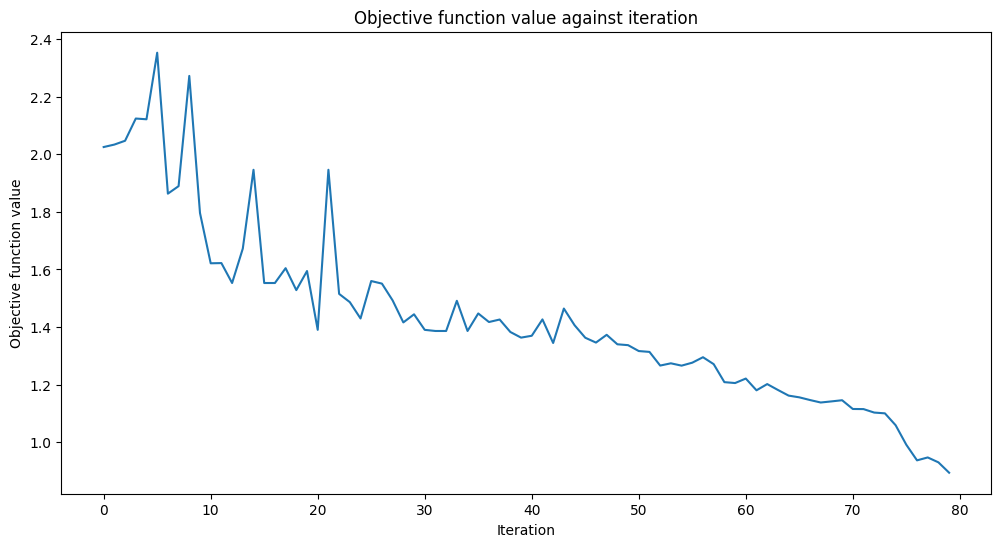

Training time: 16 seconds


In [65]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=80)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [66]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.75
Quantum VQC on the test dataset using EfficientSU2:     0.80


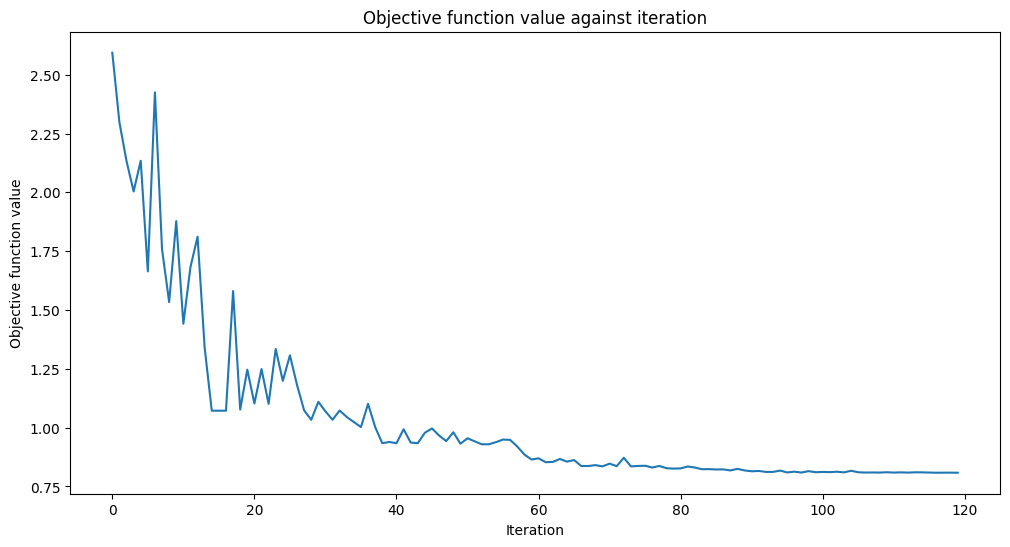

Training time: 24 seconds


In [69]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=120)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [70]:
train_score_q2_eff_reps = vqc.score(train_features, train_labels)
test_score_q2_eff_reps = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff_reps:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff_reps:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.77
Quantum VQC on the test dataset using EfficientSU2:     0.80


The scores are better than in the previous setup. With increasing the iterations of the optimizer we have results comparable to the ones the qml model with 4 features! 



### 4. Comparing Results

In this tutorial, we have built two classical and three quantum machine learning models. Let’s print an overall table with our results.

In [72]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")
print(f"VQC, 2 features, EfficientSU2 2 | {train_score_q2_eff_reps:10.2f} | {test_score_q2_eff_reps:10.2f}")

Model                           | Test Score | Train Score
SVC, 4 features                 |       0.99 |       0.97
VQC, 4 features, RealAmplitudes |       0.85 |       0.87
----------------------------------------------------------
SVC, 2 features                 |       0.97 |       0.90
VQC, 2 features, RealAmplitudes |       0.58 |       0.63
VQC, 2 features, EfficientSU2   |       0.75 |       0.80
VQC, 2 features, EfficientSU2 2 |       0.77 |       0.80


While it's no surprise that classical models currently outperform their quantum counterparts, it's essential to recognize the evolving landscape of machine learning. Classical machine learning has made significant strides, while quantum machine learning is still in its nascent stages. Our experimentation reveals that classical support vector machines yield the best results, underscoring the current dominance of classical methods. However, our quantum model trained on the full feature set demonstrates promising performance, indicating the potential of quantum techniques, especially with larger datasets.

Furthermore, our exploration highlights the importance of hyperparameter selection in both classical and quantum machine learning. Even a simple change in the ansatz architecture, such as employing the EfficientSU2 ansatz over RealAmplitudes, can lead to improved results. This emphasizes the need for meticulous hyperparameter tuning, a process that may require considerable time and effort.

In navigating the transition from classical to quantum machine learning, it's crucial to consider the trade-offs between dataset size, training time, and model performance. While training on the full feature set is ideal, resource constraints may necessitate feature reduction. Balancing these factors requires careful consideration and may involve compromise.

Ultimately, this tutorial serves as a stepping stone for those venturing into the realm of quantum machine learning. By applying established techniques from classical machine learning and embracing the nuances of quantum methods, we can pave the way for innovative advancements in the field.

In [73]:
import tutorial_magics

%qiskit_version_table